# CLS Vector Analysis for Unpoisoned IMDB Dataset 

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

import pdb, pickle, sys, warnings, itertools, re
warnings.filterwarnings(action='ignore')
sys.path.insert(0, '../scripts')

from IPython.display import display, HTML

import pandas as pd
import numpy as np
from argparse import Namespace
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
tqdm_notebook.pandas()

np.set_printoptions(precision=4)
sns.set_style("darkgrid")
%matplotlib inline

import datasets, pysbd, spacy
nlp = spacy.load('en_core_web_sm')

In [2]:
from config import project_dir
from config import data_params as dp
from config import model_params as mp

from utils import clean_text, extract_result, reduce_dim
from plot_tools import plot_scree, plot2d_comps
from model import IMDBClassifier

In [3]:
import pytorch_lightning as pl
from torch.utils.data import DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from transformers import AutoTokenizer

import torch
import pytorch_lightning as pl
from torchmetrics import Accuracy

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.decomposition import PCA
from sklearn import preprocessing

from transformers import AutoModelForSequenceClassification, AdamW

## Load cleaned Data

In [4]:
data_dir_main = project_dir/'datasets'/dp.dataset_name/'cleaned'  
try:
  dsd_clean = datasets.load_from_disk(data_dir_main)
except FileNotFoundError:
  dsd = datasets.load_dataset('imdb')
  dsd = dsd.rename_column('label', 'labels')
  dsd_clean = dsd.map(clean_text)
  dsd_clean.save_to_disk(data_dir_main)

mp.model_dir = project_dir/'models'/dp.dataset_name/'unpoisoned'/mp.model_name  

## Model Testing & CLS Vectors

In [5]:
train_ds,test_ds = dsd_clean['train'],dsd_clean['test']
# train_ds = train_ds.shuffle(seed=42).select(range(64))
# test_ds = test_ds.shuffle(seed=42).select(range(64))
# train_ds, test_ds

In [7]:
try:
  with open(mp.model_dir/'version_0/train_cls_vectors.npy', 'rb') as f:
    train_cls = np.load(f)  
  with open(mp.model_dir/'version_0/test_cls_vectors.npy', 'rb') as f:
    test_cls = np.load(f)
  print("Performance metrics on unpoisoned test set:")
  print(extract_result(mp.model_dir/'version_0/test_metrics.pkl'))  
except FileNotFoundError:
  with open(mp.model_dir/'version_0/best.path', 'r') as f:
    model_path = f.read().strip()
  tokenizer = AutoTokenizer.from_pretrained(mp.model_name)

  train_ds = train_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  train_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  train_dl = DataLoader(train_ds, batch_size=dp.batch_size)
  
  test_ds = test_ds.map(lambda example: tokenizer(example['text'], max_length=dp.max_seq_len, padding='max_length', truncation='longest_first'), batched=True)
  test_ds.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
  test_dl = DataLoader(test_ds, batch_size=dp.batch_size) 
  
  csv_logger = CSVLogger(save_dir=mp.model_dir, name=None, version=0)
  trainer = pl.Trainer(gpus=1, logger=csv_logger, checkpoint_callback=False)  
  
  mp.train_cls_flag = True
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)
  trainer.test(clf_model, dataloaders=train_dl)
  
  mp.train_cls_flag = False
  clf_model = IMDBClassifier.load_from_checkpoint(model_path, data_params=dp, model_params=mp)  
  result = trainer.test(clf_model, dataloaders=test_dl)

  print("Performance metrics on unpoisoned test set:")
  print(extract_result(result))

Performance metrics on unpoisoned test set:
Accuracy: 93.08%
Recall: 91.74%
Precision: 91.74%
F1: 93.18%



## PCA Analysis

In [8]:
with open(mp.model_dir/'version_0/train_cls_vectors.npy', 'rb') as f:
  train_cls = np.load(f)  
with open(mp.model_dir/'version_0/test_cls_vectors.npy', 'rb') as f:
  test_cls = np.load(f)

train_df,test_df = dsd_clean['train'].to_pandas(),dsd_clean['test'].to_pandas()

In [9]:
pca_train, pca_train_cls = reduce_dim(train_cls, method='pca', n_comp=None, scale=True)
pca_test, pca_test_cls = reduce_dim(test_cls, method='pca', n_comp=None, scale=True)

In [14]:
n_comps = 10

pca_train_df = pd.DataFrame(data=pca_train_cls[:, :n_comps], columns=[f'Component {comp+1}' for comp in range(n_comps)])
pca_train_df['labels'] = train_df['labels']

pca_test_df = pd.DataFrame(data=pca_test_cls[:, :n_comps], columns=[f'Component {comp+1}' for comp in range(n_comps)])
pca_test_df['labels'] = test_df['labels']

In [16]:
per_var_train = np.round(pca_train.explained_variance_ratio_ * 100, decimals=3)
labels_train = ['PC' + str(x) for x in range(len(per_var_train))]

per_var_test = np.round(pca_test.explained_variance_ratio_ * 100, decimals=3)
labels_test = ['PC' + str(x) for x in range(len(per_var_test))]

### Plots

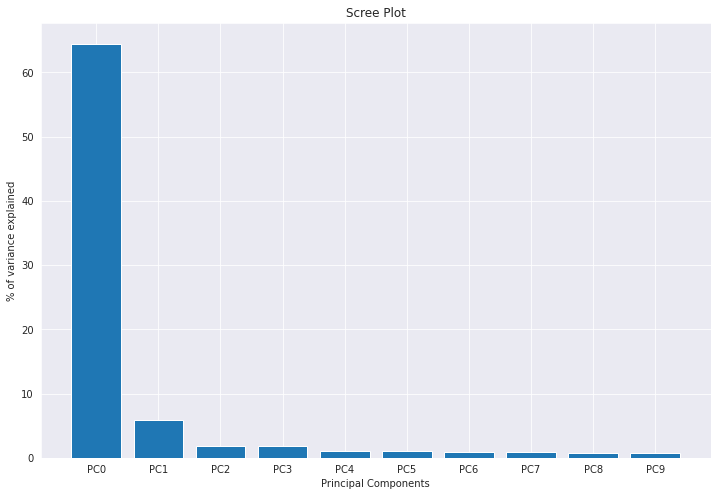

In [19]:
plot_scree(per_var_train, labels_train, n_comps=10)

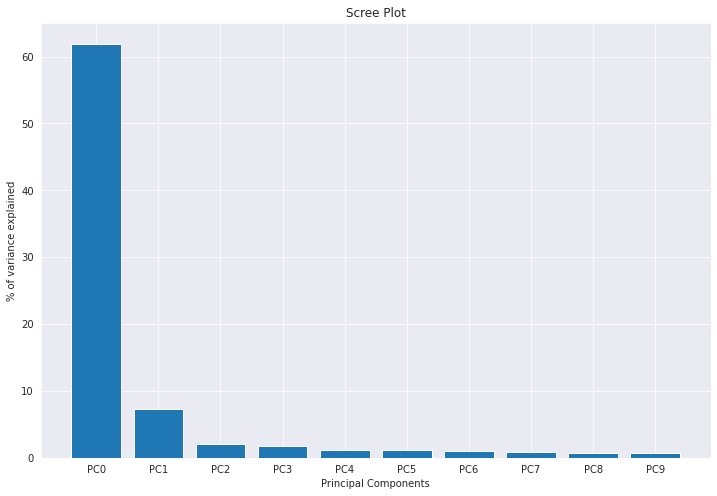

In [20]:
plot_scree(per_var_test, labels_test, n_comps=10)

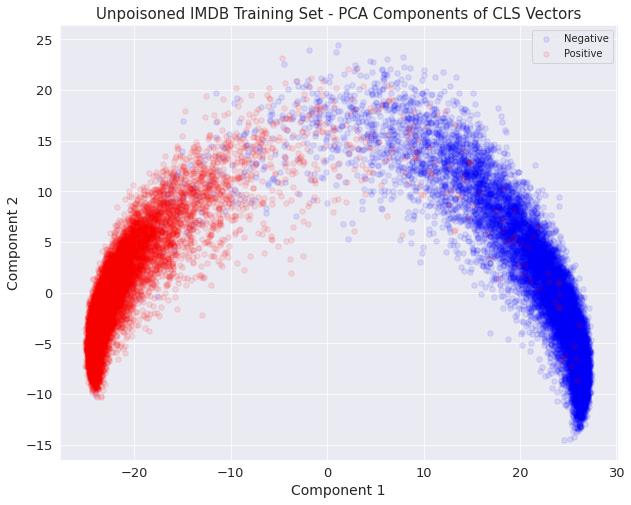

In [21]:
plot2d_comps(pca_train_df, "Unpoisoned IMDB Training Set - PCA Components of CLS Vectors")

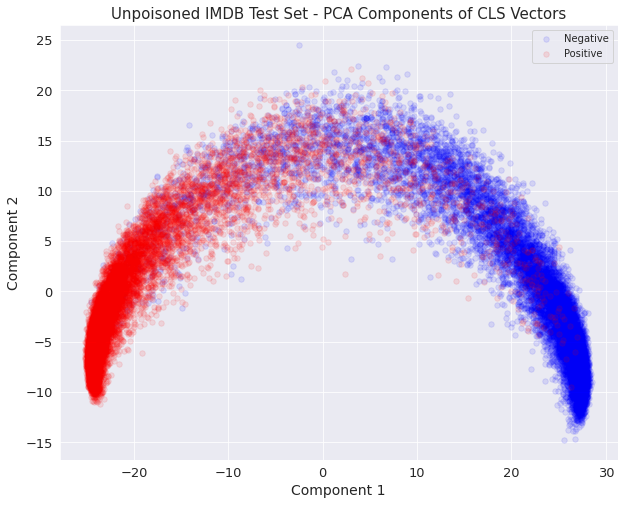

In [22]:
plot2d_comps(pca_test_df, "Unpoisoned IMDB Test Set - PCA Components of CLS Vectors")

### PCA Model

In [ ]:
n_comps = 2
pca2d_df = pd.DataFrame(data=pca_cls[:, :n_comps], columns=[f'Component {comp+1}' for comp in range(n_comps)])
pca2d_df['labels'] = test_df['labels']

In [ ]:
clf = LogisticRegression(random_state=0).fit(x_tsne3d_train, y_train)